In [2]:
from PIL import Image

from PIL.TiffTags import TAGS
import re
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.transform import Affine
import numpy as np 
import cv2
import imutils
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from io import BytesIO



In [157]:
def metadata(imagen):
    img = Image.open(imagen)
# obtenemos los Tags de la metadata y se almacenan en un diccionario
    meta_dict = {TAGS[key]: img.tag[key] for key in img.tag_v2}
    # Se imprime el diccionario para obtener la composición de los datos
    # for rec in meta_dict:
    #     print(rec, ":", meta_dict[rec])

    # Extraemos el indicador xmp
    p = meta_dict.get("XMP")
    s = p.decode("UTF-8")
    # dividimos por el salto de linea y obtenemos una lista
    div = s.split("\n")

    #eliminamos los espacios vacios 

    for ind,recorrido in enumerate(div):
        div[ind]=recorrido.strip() 
    usar = div[17]

    result = re.search(":(.*)=", div[17])
    result.group(1)

    result2 = re.search("\"(.*)\"", div[17])
    result2.group(1)

    metadiccionario = {}
    for ind,recorrido in enumerate(div):
        try:
            metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
        except:
            pass

    metadiccionario = {}
    for ind,recorrido in enumerate(div):
        try:
            metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
        except:
            pass

    #print(metadiccionario)
    return metadiccionario

def TransfromRaster(img_path, xy_in, latlon_in):
    metadiccionario = metadata(img_path)
    
    altura_vuelo = float(metadiccionario["RelativeAltitude"])
    distancia_focal = float(metadiccionario["CalibratedFocalLength"])

    resolucion = altura_vuelo/distancia_focal
    #print(metadiccionario["GpsLongitude"])
    #print(metadiccionario["GpsLatitude"])
    min_lon = (float(metadiccionario["GpsLongitude"])) - (
        float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
    max_lon = (float(metadiccionario["GpsLongitude"])) + (
        float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
    min_lat = (float(metadiccionario["GpsLatitude"])) - (
        float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
    max_lat = (float(metadiccionario["GpsLatitude"])) + (
        float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111

    img_data = rasterio.open(img_path, 'r')

    bands = [1] #Se especifica las cantidades de canales que tiene la imagen.

    data = img_data.read(bands)
    _, width, height = data.shape #width corresponde al eje x y height al eje y

    transform = rasterio.transform.from_bounds(
            min_lon, min_lat, max_lon, max_lat, height, width)
    
    transform_xy_to_latlon = np.array([[transform.a, transform.b, transform.c], 
                                       [transform.d, transform.e, transform.f],
                                       [0, 0, 1]], dtype =np.float64)

  
    xy = np.array([[xy_in[0]],
                   [xy_in[1]],
                   [1]], dtype=np.float64)
    
    xy_to_latlon = np.dot(transform_xy_to_latlon, xy)


    latlon = np.array([[latlon_in[0]],
                       [latlon_in[1]],
                       [1]], dtype=np.float64)
    
    transform_latlon_to_xy = np.linalg.inv(transform_xy_to_latlon)
    
    print(np.dot(transform_latlon_to_xy, latlon))
    

    return xy_to_latlon



In [4]:
img_path = "Img/DJI_0011.TIF"


metadiccionario = metadata(img_path)
print(metadiccionario)

{'xmpmeta xmlns:x': 'adobe:ns:meta/', 'RDF xmlns:rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'Description rdf:about': 'DJI Meta Data', 'tiff': 'http://ns.adobe.com/tiff/1.0/', 'exif': 'http://ns.adobe.com/exif/1.0/', 'xmp': 'http://ns.adobe.com/xap/1.0/', 'xmpMM': 'http://ns.adobe.com/xap/1.0/mm/', 'dc': 'http://purl.org/dc/elements/1.1/', 'crs': 'http://ns.adobe.com/camera-raw-settings/1.0/', 'drone-dji': 'http://www.dji.com/drone-dji/1.0/', 'Camera': 'http://pix4d.com/camera/1.0', 'ModifyDate': '2023-04-19', 'CreateDate': '2023-04-19', 'Make': 'DJI', 'Model': 'FC6360', 'format': 'image/TIF', 'AbsoluteAltitude': '+50.47', 'RelativeAltitude': '+24.90', 'GpsLatitude': '11.22467042', 'GpsLongitude': '-74.18553757', 'GimbalRollDegree': '+0.00', 'GimbalYawDegree': '+87.50', 'GimbalPitchDegree': '-89.90', 'FlightRollDegree': '+1.10', 'FlightYawDegree': '+87.50', 'FlightPitchDegree': '-5.00', 'FlightXSpeed': '+0.00', 'FlightYSpeed': '+0.00', 'FlightZSpeed': '+0.10', 'CamReverse': '0

In [5]:
centro_x = float(metadiccionario["CalibratedOpticalCenterX"])
centro_y = float(metadiccionario["CalibratedOpticalCenterY"])
latitud = float(metadiccionario["GpsLatitude"])
longitud = float(metadiccionario["GpsLongitude"])

centro_rela_x = float(metadiccionario["RelativeOpticalCenterX"])
centro_rela_y = float(metadiccionario["RelativeOpticalCenterY"])

print(f"Centro\nx: {centro_x}, y: {centro_y}")

print(f"Latitud: {latitud}, Longitud: {longitud}")



Centro
x: 800.0, y: 650.0
Latitud: 11.22467042, Longitud: -74.18553757


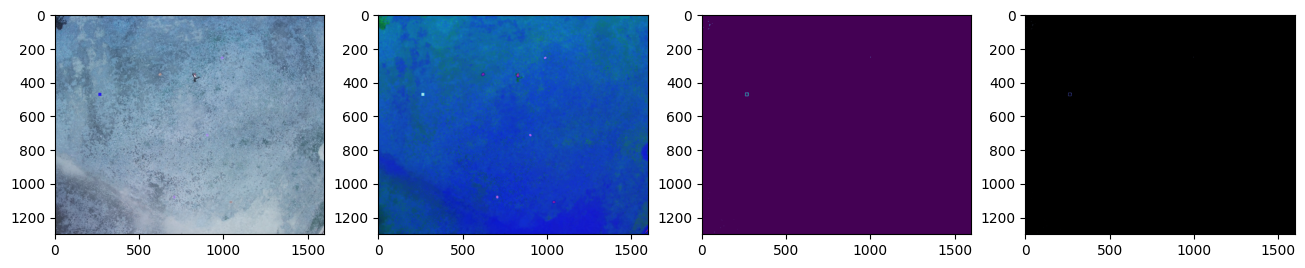

In [156]:
img_punto = cv2.imread("./Img/DJI_0050.JPG", -1)
img_path = "Img/DJI_0051.TIF"

umbral_bajo1 = (170,100,100)
umbral_alto1 = (179,255,255)
# Elegimos el segundo umbral de rojo en HSV
umbral_bajo2 = (0,100,100)
umbral_alto2 = (10,255,255)

#img_bgr = cv2.cvtColor(img_punto, cv2.COLOR_)
img_hvs = cv2.cvtColor(img_punto, cv2.COLOR_BGR2HSV)

mask1= cv2.inRange(img_hvs, umbral_bajo1, umbral_alto1)
mask2= cv2.inRange(img_hvs, umbral_bajo2, umbral_alto2)


maskRedvis = cv2.bitwise_and(img_punto, img_punto, mask= mask2)
plt.figure(figsize=(16,16))
plt.subplot(1, 4, 1)
plt.imshow(img_punto)

plt.subplot(1, 4, 2)
plt.imshow(img_hvs)

plt.subplot(1, 4, 3)
plt.imshow(mask2)

plt.subplot(1, 4, 4)
plt.imshow(maskRedvis)



In [63]:
y, x = img_punto.shape[:2]
y_out = []
x_out = []
for i in range(y):
    for j in range(x):
        for k in range(3):  
            if(maskRedvis[i][j][k] != 0):
                if(i>400 and i<600 and j>250 and j<500):
                    if (k==0):
                        maskRedvis[i][j][0] = 255
                        maskRedvis[i][j][1] = 0
                        maskRedvis[i][j][2] = 0
                        y_out.append(i)
                        x_out.append(j)

                        

                   



In [158]:
max_x = max(x_out)
max_y = max(y_out)

min_x = min(x_out)
min_y = min(y_out)
iz_s = [min_x, min_y]
de_i = [max_x, max_y]

cxy = [min_x + int((max_x - min_x)/2), min_y + int((max_y - min_y)/2)]

print("[---- Punto 1 ----] ")
print(f" Centro Punto 1 (Pixeles) \n  x: {cxy[0]}  \n  y: {cxy[1]}")

cxy_transform = TransfromRaster(img_path, cxy, [0, 0])

print(f" Centro Punto 1 (Longitud - Latitud) \n  Lon: {cxy_transform[0][0]}  \n  Lat: {cxy_transform[1][0]}")

print("\n")
""""
print(f" Esquina Superior Izquierda Punto 1 (Pixeles) \n  x: {iz_s[0]}  \n  y: {iz_s[0]}")

iz_s_transform = TransfromRaster(img_path, iz_s)

print(f" Centro Punto 1 (Longitud - Latitud) \n  Lon: {iz_s_transform[0][0]}  \n  Lat: {iz_s_transform[1][0]}")
"""
puntos = ["DJI_0061", "DJI_0071", "DJI_0081", "DJI_0091", "DJI_0101", "DJI_0111"]


#No se puede verificar la precision de los puntos porque la imagen no contiene altura.
for i in puntos:
    img_path1 = "Img/"+ i + ".TIF"
    dicc = metadata(img_path1)
    latitud = float(dicc["GpsLatitude"])
    longitud = float(dicc["GpsLongitude"])

    print(f" Centro " + i + f" \n  Lon: {longitud}  \n  Lat: {latitud}")
    cxy_transform = TransfromRaster(img_path, [0, 0], [latitud, longitud])
    print("\n")

""""
print(iz_s, de_i)

maskRedvis[min_y][min_x][0] = 255
maskRedvis[min_y][min_x][1] = 255
maskRedvis[min_y][min_x][2] = 255

maskRedvis[max_y][max_x][0] = 255
maskRedvis[max_y][max_x][1] = 255
maskRedvis[max_y][max_x][2] = 255

maskRedvis[cxy[1]][cxy[0]][0] = 255
maskRedvis[cxy[1]][cxy[0]][1] = 255
maskRedvis[cxy[1]][cxy[0]][2] = 255


plt.imshow(maskRedvis)

"""



[---- Punto 1 ----] 
 Centro Punto 1 (Pixeles) 
  x: 265  
  y: 474
[[6.23864607e+08]
 [9.43945063e+07]
 [1.00000000e+00]]
 Centro Punto 1 (Longitud - Latitud) 
  Lon: -74.18558575845948  
  Lat: 11.224678358689474


 Centro DJI_0061 
  Lon: -74.1854916  
  Lat: 11.22472608
[[7.18259041e+08]
 [7.18258057e+08]
 [1.00000000e+00]]


 Centro DJI_0071 
  Lon: -74.18547806  
  Lat: 11.22468195
[[7.18258670e+08]
 [7.18257943e+08]
 [1.00000000e+00]]


 Centro DJI_0081 
  Lon: -74.18546521  
  Lat: 11.22463691
[[7.18258291e+08]
 [7.18257835e+08]
 [1.00000000e+00]]


 Centro DJI_0091 
  Lon: -74.18545444  
  Lat: 11.22455292
[[7.18257585e+08]
 [7.18257744e+08]
 [1.00000000e+00]]


 Centro DJI_0101 
  Lon: -74.18552152  
  Lat: 11.22464698
[[7.18258376e+08]
 [7.18258308e+08]
 [1.00000000e+00]]


 Centro DJI_0111 
  Lon: -74.18556667  
  Lat: 11.22467064
[[7.18258575e+08]
 [7.18258688e+08]
 [1.00000000e+00]]




'"\nprint(iz_s, de_i)\n\nmaskRedvis[min_y][min_x][0] = 255\nmaskRedvis[min_y][min_x][1] = 255\nmaskRedvis[min_y][min_x][2] = 255\n\nmaskRedvis[max_y][max_x][0] = 255\nmaskRedvis[max_y][max_x][1] = 255\nmaskRedvis[max_y][max_x][2] = 255\n\nmaskRedvis[cxy[1]][cxy[0]][0] = 255\nmaskRedvis[cxy[1]][cxy[0]][1] = 255\nmaskRedvis[cxy[1]][cxy[0]][2] = 255\n\n\nplt.imshow(maskRedvis)\n\n'